# Beacon localization with Neural Networks - Prediction
In this project dat from N=3 different beacons are used to get the location of the device in the space


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf # v 1.0 or higher
import numpy as np # version 1.13 required
import pandas as pd
import glob, os
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

## Load Data
Here we load all CSV files

In [2]:
data_path = 'c:/Users/E411208/Documents/Python Scripts/data/Bluetooth/'
data = pd.DataFrame()

for id,file in enumerate(os.listdir(data_path)):
    if file.endswith(".csv"):
        print('Loading file ... ' + file)
        measurement = pd.read_csv(data_path + file)
        measurement['measurement']=id 
        data = data.append(measurement,ignore_index = True)


Loading file ... 01_stat_20170627T1723_Nexus 5X.csv
Loading file ... 02_stat_20170627T1730_Nexus 5X.csv
Loading file ... 03_stat_20170627T1736_Nexus 5X.csv
Loading file ... 04_stat_20170627T1742_Nexus 5X.csv
Loading file ... 05_stat_20170627T1748_Nexus 5X.csv
Loading file ... 06_stat_20170627T1753_Nexus 5X.csv
Loading file ... 07_stat_20170627T1759_Nexus 5X.csv
Loading file ... 08_stat_20170627T1805_Nexus 5X.csv
Loading file ... 09_stat_20170627T1812_Nexus 5X.csv
Loading file ... 10_stat_20170627T1820_Nexus 5X.csv
Loading file ... 11_stat_20170627T1826_Nexus 5X.csv
Loading file ... 12_stat_20170627T1832_Nexus 5X.csv


In [3]:
data.head()

,device_x,device_y,device_z,time,beacon_9827_x,beacon_9827_y,beacon_9827_z,beacon_9827_d,beacon_9841_x,beacon_9841_y,...,beacon_10197_d,beacon_10203_x,beacon_10203_y,beacon_10203_z,beacon_10203_d,beacon_10214_x,beacon_10214_y,beacon_10214_z,beacon_10214_d,measurement
0,22.0,3.5,1.1,2017-01-01T17:24:39,27.0,-4.5,1.1,1.98,3.0,21.0,...,1.70,18.5,19.5,1.1,NaN,13.0,19.5,1.1,NaN,0
1,22.0,3.5,1.1,2017-01-01T17:24:40,27.0,-4.5,1.1,1.80,3.0,21.0,...,1.68,18.5,19.5,1.1,NaN,13.0,19.5,1.1,NaN,0
2,22.0,3.5,1.1,2017-01-01T17:24:41,27.0,-4.5,1.1,1.52,3.0,21.0,...,1.68,18.5,19.5,1.1,NaN,13.0,19.5,1.1,NaN,0
3,22.0,3.5,1.1,2017-01-01T17:24:42,27.0,-4.5,1.1,1.52,3.0,21.0,...,1.66,18.5,19.5,1.1,NaN,13.0,19.5,1.1,NaN,0
4,22.0,3.5,1.1,2017-01-01T17:24:44,27.0,-4.5,1.1,1.51,3.0,21.0,...,1.70,18.5,19.5,1.1,NaN,13.0,19.5,1.1,NaN,0


## Scale data
Shift and scale the variables such that they have zero mean and a standard deviation of 1. The scaling factors are saved so we can go backwards when we use the network for predictions.

In [4]:
list_of_beacons = data.keys()[4:-1] # skip device and time and measurement
list_of_devices = [k for k in data.keys()[:3] if not('_d') in k]


list_beacon_x = [k for k in list_of_beacons if ('_x') in k]
list_beacon_y = [k for k in list_of_beacons if ('_y') in k]
list_beacon_z = [k for k in list_of_beacons if ('_z') in k]
N_beacons = len(list_beacon_x)
print('Number of beacons is ',N_beacons)

# scale the x,y,z coordinates
list_coordinates = list_of_devices + list_beacon_x + list_beacon_y + list_beacon_z  
mean_coordinates, std_coordinates = data[list_coordinates].stack().mean(), data[list_coordinates].stack().std()
data.loc[:,list_coordinates] = (data[list_coordinates] - mean_coordinates)/std_coordinates

#scale the distances 
list_beacon_d = [k for k in list_of_beacons if ('_d') in k]
mean_distances, std_distances = data[list_beacon_d].stack().mean(), data[list_beacon_d].stack().std()    
data.loc[:,list_beacon_d] = (data[list_beacon_d] - mean_distances)/std_distances

Number of beacons is  20


In [5]:
data.head()

,device_x,device_y,device_z,time,beacon_9827_x,beacon_9827_y,beacon_9827_z,beacon_9827_d,beacon_9841_x,beacon_9841_y,...,beacon_10197_d,beacon_10203_x,beacon_10203_y,beacon_10203_z,beacon_10203_d,beacon_10214_x,beacon_10214_y,beacon_10214_z,beacon_10214_d,measurement
0,0.846668,-0.739486,-0.945257,2017-01-01T17:24:39,1.275358,-1.42539,-0.945257,-0.272303,-0.782355,0.76093,...,-0.463948,0.546585,0.632323,-0.945257,NaN,0.075026,0.632323,-0.945257,NaN,0
1,0.846668,-0.739486,-0.945257,2017-01-01T17:24:40,1.275358,-1.42539,-0.945257,-0.395503,-0.782355,0.76093,...,-0.477637,0.546585,0.632323,-0.945257,NaN,0.075026,0.632323,-0.945257,NaN,0
2,0.846668,-0.739486,-0.945257,2017-01-01T17:24:41,1.275358,-1.42539,-0.945257,-0.587148,-0.782355,0.76093,...,-0.477637,0.546585,0.632323,-0.945257,NaN,0.075026,0.632323,-0.945257,NaN,0
3,0.846668,-0.739486,-0.945257,2017-01-01T17:24:42,1.275358,-1.42539,-0.945257,-0.587148,-0.782355,0.76093,...,-0.491326,0.546585,0.632323,-0.945257,NaN,0.075026,0.632323,-0.945257,NaN,0
4,0.846668,-0.739486,-0.945257,2017-01-01T17:24:44,1.275358,-1.42539,-0.945257,-0.593993,-0.782355,0.76093,...,-0.463948,0.546585,0.632323,-0.945257,NaN,0.075026,0.632323,-0.945257,NaN,0


## Train/Validation/Test set
The data are split in 3 datasets. From each measurement use 80% is for training, 10% for validation and 10% for testing

In [6]:
train = pd.DataFrame()
valid = pd.DataFrame()
test = pd.DataFrame()

for measurement in range(0,data['measurement'].max()+1):
    subdata = data[data['measurement'] == measurement]
    length = len(subdata.index)
    train_idx = int(length*0.8)
    valid_idx = int(length*0.9)
    train = train.append(subdata.iloc[:train_idx])
    valid = valid.append(subdata.iloc[train_idx:valid_idx])
    test  = test.append(subdata.iloc[valid_idx:])


In [7]:
print(len(data.index),'All data lines')
print(len(train.index),'Training data lines')
print(len(valid.index),'Validation data lines')
print(len(test.index),'Testing data lines')

2304 All data lines
1837 Training data lines
228 Validation data lines
239 Testing data lines


## Data Augmentation
Every timestamp has various number of beacon measurements (3-20). The input to the network will take information from ALL beacons and try to predict the location of the device.  The becons with distance equal to NaN will have cooridnates set to 0

How many beacons is required to get descent output?

In [8]:
from itertools import combinations

def augmented_data(in_data):
    out_data_x = list()
    out_data_y = list()
    for index, row in in_data.iterrows():
        if index % 100 == 0: print('Number of processed rows ...',index)
        
        # set zero to beacons coordinates & distance if distance == NaN 
        out_data_y.extend([row['device_x'],row['device_y'],row['device_z']]) 

        for idx,beacon in enumerate(list_beacon_d):
            if pd.isnull(row[beacon]):
                out_data_x.extend([0,0,0,0])
            else:    
                out_data_x.extend([row[list_beacon_x[idx]],row[list_beacon_y[idx]],row[list_beacon_z[idx]],row[list_beacon_d[idx]]])

    out_data_x = np.reshape(out_data_x,[-1,N_beacons*4]) #all 20 beacons [x,y,z,d]            
    out_data_y = np.reshape(out_data_y,[-1,3]) # device [x,y,z]
    return out_data_x,out_data_y
                
def augmented_data_N_selected_beacons(in_data):    
    out_data_x = list()
    out_data_y = list()
    for index, row in in_data.iterrows():
        if index % 100 == 0: print('Number of processed rows ...',index)
    

        inds_dist = (np.where(row[list_beacon_d].notnull())[0]) #find distancec != NaN
        inds_combination = list(combinations(inds_dist, N)) # create nonrepeating variations from existing distances
        for inds in inds_combination:
            out_data_y.extend([row['device_x'],row['device_y'],row['device_z']]) 
            for idx,beacon in enumerate(list_beacon_d):
                if idx in inds:
                    out_data_x.extend([row[list_beacon_x[idx]],row[list_beacon_y[idx]],row[list_beacon_z[idx]],row[list_beacon_d[idx]]])
                else:    
                    out_data_x.extend([0,0,0,0])

    out_data_x = np.reshape(out_data_x,[-1,N_beacons*4]) #all 20 beacons [x,y,z,d]            
    out_data_y = np.reshape(out_data_y,[-1,3]) # device [x,y,z]
    return out_data_x,out_data_y


#augmented_data(train[:1])
train_x,train_y = augmented_data(train)
val_x,val_y = augmented_data(valid)
test_x,test_y = augmented_data(test)

Number of processed rows ... 0
Number of processed rows ... 100
Number of processed rows ... 200
Number of processed rows ... 300
Number of processed rows ... 400
Number of processed rows ... 500
Number of processed rows ... 600
Number of processed rows ... 700
Number of processed rows ... 800
Number of processed rows ... 900
Number of processed rows ... 1000
Number of processed rows ... 1100
Number of processed rows ... 1200
Number of processed rows ... 1300
Number of processed rows ... 1400
Number of processed rows ... 1600
Number of processed rows ... 1800
Number of processed rows ... 2000
Number of processed rows ... 2200
Number of processed rows ... 1500
Number of processed rows ... 1700
Number of processed rows ... 1900
Number of processed rows ... 2100
Number of processed rows ... 2300


In [9]:
print(train.shape)
print(train_x.shape)
print(val_x.shape)
print(test_x.shape)

(1837, 85)
(1837, 80)
(228, 80)
(239, 80)


## Visualize training data
show a 3D scatter plot where x,y,z represents distance from beacon 1,2,3

In [10]:
data = list()
# select the points with same coordinates
single_points = np.unique(test_y,axis=0)
for point in single_points[:,:]:
    # select all points for the distance of respective beacon
    # test_x = [b1_x,b1_y,b1_z,b1_d,b2_x,b2_y,b2_z,b2_d,b3_x,b3_y,b3_z,b3_d]
    b1 = np.transpose(train_x[:,3])*std_distances + mean_distances
    b2 = np.transpose(train_x[:,7])*std_distances + mean_distances
    b3 = np.transpose(train_x[:,11])*std_distances + mean_distances
    
    # find distances for selected points
    idx = np.where(np.all(train_y == point,axis=-1))
    
    ########################
    # save data to Plotly
    ########################
    trace = go.Scatter3d(
        x=b1[idx],
        y=b2[idx],
        z=b3[idx],
        mode='markers',
        marker=dict(
            size=12,
            line=dict(
                color=np.random.randn(500),
                colorscale='Viridis',
                width=0
            ),
            opacity=0.3
        )
    )

    data.append(trace)

#########################
# create layout and graph
#########################
print(type(data))
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = plotly.graph_objs.Figure(
    data=data,
    layout=layout
)
plotly.offline.plot(fig,filename='train-data.html')

<class 'list'>


'file://C:\\Users\\E411208\\Documents\\Python Scripts\\Beacon\\train-data.html'

In [11]:
%%HTML
<iframe id="plot" src="train-data.html" seamless></iframe>

<style type="text/css">
iframe{
  width: 800px;
  height: 600px;
  border : none;
  z-index: 2;
}

# Neural Network
Construct a network that takes on input signals from 3 beacons and their x,y,z coordinates + distance, have one nonlinear hidden layer and output x,y,z, coordinates of the device

In [12]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

learning_rate = 0.001;
num_outputs = 3;

x = tf.placeholder('float32',[None,N_beacons*4])
y = tf.placeholder('float32',[None,num_outputs])

#####################################
## Create the Neural Network Model ##
#####################################

def fully_conn(input, hiddens):
    input_shape = input.get_shape().as_list()
    std_init = 1/np.sqrt(input_shape[1])
    weight = tf.Variable(tf.truncated_normal([input_shape[1],hiddens], stddev=std_init)) 
    bias = tf.Variable(tf.constant(0.1, shape=[hiddens]))
    full_bias = tf.add(tf.matmul(input,weight),bias,name='full_bias')
    return tf.nn.elu(full_bias,name='fc_relu')

def output(input, num_outputs):
    input_shape = input.get_shape().as_list()
    std_init = 1/np.sqrt(input_shape[1])
    weight = tf.Variable(tf.truncated_normal([input_shape[1],num_outputs], stddev=std_init)) 
    return tf.matmul(input,weight, name='output')    

def network(input,num_outputs):
    hidden1 = fully_conn(input,20)
    hidden2 = fully_conn(hidden1,50)
    hidden3 = fully_conn(hidden2,100)
    out = output(hidden3,num_outputs)
    return out

##############################
## Build the Neural Network ##
##############################

# Model predicting the x,y,z of the device
pred =  network(x,num_outputs)

# Loss and Optimizer
cost = tf.reduce_mean(tf.square(pred - y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


## Prepare batches for training

In [13]:
def get_batches(x, y, n_batches=20):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else: X, Y = x[ii:], y[ii:]
        # I love generators
        yield X, Y

## Network training

In [ ]:
all_iteration = list()
all_train_loss = list()
all_val_loss = list()
epochs = 700
iteration = 0
saver = tf.train.Saver()
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for t_x, t_y in get_batches(train_x, train_y):
            feed = {x: t_x.astype(np.float32), 
                    y: t_y.astype(np.float32)}
            loss, _ = sess.run([cost, optimizer], feed_dict=feed)
#             print("Epoch: {}/{}".format(e+1, epochs),
#                   "Iteration: {}".format(iteration),
#                   "Training loss: {:.5f}".format(loss))
            iteration += 1
            
            if iteration % 100 == 0:
                all_iteration.append(iteration)
                feed = {x: train_x,
                        y: train_y}
                train_loss = sess.run(cost, feed_dict=feed)  
                all_train_loss.append(train_loss)
                feed = {x: val_x,
                        y: val_y}
                val_loss = sess.run(cost, feed_dict=feed)
                all_val_loss.append(val_loss)
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Training loss: {:.5f}".format(train_loss),
                      "Validation loss: {:.4f}".format(val_loss))
    saver.save(sess, "checkpoints-prediction/dev_loc.ckpt")

### visualize training/validation Loss

In [ ]:
plt.plot(all_iteration,all_train_loss,label='train loss')
plt.plot(all_iteration,all_val_loss, label='validation loss')
plt.legend()

## TEST NETWORK - Check the result on testing data 

In [17]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-prediction'))
    
    feed = {x: test_x,
            y: test_y}
    out = sess.run(pred, feed_dict=feed)
    test_loss = sess.run(cost, feed_dict=feed)
    print("Test loss: {:.4f}".format(test_loss))

INFO:tensorflow:Restoring parameters from checkpoints-prediction\dev_loc.ckpt
Test loss: 0.0321


### visualize prediction results

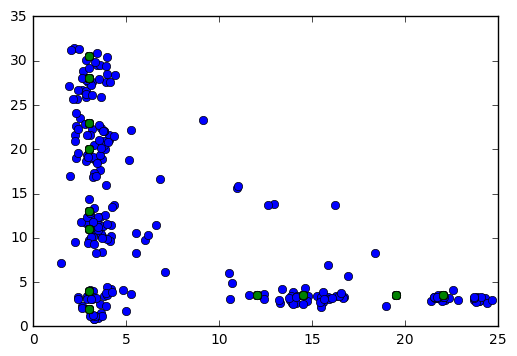

In [23]:
plt.plot(out[:,0]*std_coordinates + mean_coordinates,
         out[:,1]*std_coordinates + mean_coordinates,
         linestyle='None',
         marker='o')
plt.plot(test_y[:,0]*std_coordinates + mean_coordinates,test_y[:,1]*std_coordinates + mean_coordinates,marker='o',linestyle='None')

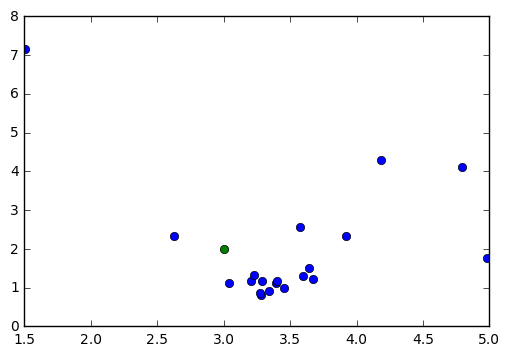

In [19]:
# visualize single point and its prediction

single_points = np.unique(test_y,axis=0)
#print(single_points)
point = single_points[0,:]
idx = np.where(np.all(test_y == point,axis=-1))
x = np.transpose(out[idx,0])
y = np.transpose(out[idx,1])
plt.plot(x*std_coordinates + mean_coordinates,y*std_coordinates + mean_coordinates,linestyle='None',marker='o')
plt.plot(point[0]*std_coordinates + mean_coordinates,point[1]*std_coordinates + mean_coordinates,linestyle='None',marker='o')

In [20]:
trace1 = go.Scatter(
    x = out[:,0]*std_coordinates + mean_coordinates,
    y = out[:,1]*std_coordinates + mean_coordinates,
    mode = 'markers',
    text= test.index
)

trace2 = go.Scatter(
    x = test_y[:,0]*std_coordinates + mean_coordinates,
    y = test_y[:,1]*std_coordinates + mean_coordinates,
    mode = 'markers'
)


data1 = [trace1, trace2]

layout1 = go.Layout( 
    title="testing results", 
    hovermode ='closest',
)    

fig = plotly.graph_objs.Figure(
    data=data1,
    layout=layout1
)
plotly.offline.plot(fig,filename='test-results.html')

'file://C:\\Users\\E411208\\Documents\\Python Scripts\\Beacon\\test-results.html'

In [21]:
idx_b = 3
data_test = list()
for idx,each in  enumerate(list_beacon_d):
    #label = 'x' + (test[list_beacon_x[idx]]*std_coordinates + mean_coordinates).map(str) + ' y'+ (test["device_y"]*std_coordinates + mean_coordinates).map(str)
    #out = (test_y[:,0]*std_coordinates + mean_coordinates).astype('str') 
    labelx = ["%.2f" % x for x in out[:,0]*std_coordinates + mean_coordinates]
    labely = ["%.2f" % x for x in out[:,1]*std_coordinates + mean_coordinates]
    label = ['x' + i+' y'+j for i,j in zip(labelx,labely)]
    trace = go.Scatter(
        x = test.index,
        y = test_x[:,idx_b]*std_distances + mean_distances,
        mode = 'markers+lines',
        name = each,
        text = label
    )
    
    data_test.append(trace)
    idx_b += 4


layout = go.Layout( 
    title="testing inputs", 
    hovermode ='closest',
)    

fig = plotly.graph_objs.Figure(
    data=data_test,
    layout=layout
)
plotly.offline.plot(fig,filename='test-inputs.html')

'file://C:\\Users\\E411208\\Documents\\Python Scripts\\Beacon\\test-inputs.html'

In [22]:
%%HTML
<iframe id="plot" src="test-results.html" seamless></iframe>
<iframe id="plot" src="test-inputs.html" seamless></iframe>

<style type="text/css">
iframe{
  width: 800px;
  height: 600px;
  border : none;
  z-index: 2;
}

In [ ]:
#help(plotly.offline.plot)

## Show prediction in time

In [ ]:
trace1 = go.Scatter3d(
    x = out[:,0]*std_coordinates + mean_coordinates,
    y = out[:,1]*std_coordinates + mean_coordinates,
    z = test.index,
    mode = 'markers+lines',
)

data1 = [trace1]

layout1 = go.Layout( 
    title="testing results", 
    hovermode ='closest',
)    

fig = plotly.graph_objs.Figure(
    data=data1,
    layout=layout1
)
plotly.offline.plot(fig,filename='test-prediction-3D.html')

In [14]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-prediction'))
    
    feed = {x: train_x,
            y: train_y}
    out_train = sess.run(pred, feed_dict=feed)
    test_loss = sess.run(cost, feed_dict=feed)
    print("Test loss: {:.4f}".format(test_loss))

INFO:tensorflow:Restoring parameters from checkpoints-prediction\dev_loc.ckpt
Test loss: 0.0151


In [15]:
trace1 = go.Scatter(
    x = train.index,
    y = out_train[:,0]*std_coordinates + mean_coordinates,
    mode = 'markers+lines',
)

trace2 = go.Scatter(
    x = train.index,
    y = out_train[:,1]*std_coordinates + mean_coordinates,
    mode = 'markers+lines',
)

data1 = [trace1,trace2]

layout1 = go.Layout( 
    title="training predictions", 
    hovermode ='closest',
) 

fig = plotly.graph_objs.Figure(
    data=data1,
    layout=layout1
)
plotly.offline.plot(fig,filename='train-prediction.html')

'file://C:\\Users\\E411208\\Documents\\Python Scripts\\Beacon\\train-prediction.html'

In [16]:
%%HTML
<iframe id="plot" src="train-prediction.html" seamless></iframe>

<style type="text/css">
iframe{
  width: 800px;
  height: 600px;
  border : none;
  z-index: 2;
}